# Import Modules

In [1]:
import os

!git clone https://github.com/m-zayan/tfrecord-handler.git

os.chdir('/content/tfrecord-handler/')

Cloning into 'tfrecord-handler'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 2), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [2]:
from glob import glob

from IPython.display import display
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf

# handler
from tfrecord_handler.io import TfRecordWriter, TfRecordReader

# Download dataset

In [3]:
url = 'https://www.ece.nus.edu.sg/stfpage/elepv/NUS-HandSet/NUS-Hand-Posture-Dataset-II.zip'
fname = 'NUS-Hand-Posture-Dataset-II.zip'

tf.keras.utils.get_file(fname, url, extract=True, archive_format='zip')

77234176/77233719 [==============================] - 53s 1us/step


'/root/.keras/datasets/NUS-Hand-Posture-Dataset-II.zip'

In [4]:
main_path = '/root/.keras/datasets/'
fname = os.listdir(main_path)[0]

path = os.path.join(main_path, fname)

folders = ['Hand Postures', 'Hand Postures with human noise']

# Files as dataframe

In [5]:
def is_image(row):
  
  ext = ['.jpg', '.png', '.jpeg']

  if os.path.splitext(row)[-1].lower() not in ext:
    print(row)
    return None
  else:
    return row

In [6]:
def encode_class(classes):

  unique = np.unique(classes)
  y = classes.to_numpy()

  return (y.reshape(-1, 1) == unique).argmax(axis=1)

In [7]:
data = {}

for f in folders:
  files = os.listdir(os.path.join(path, f))
  
  print(f)
  
  data[f] = {'image': [], 'class': []}

  for fname in files:
    fpath = os.path.join(path + '/' + f, fname)
    data[f]['image'].append(fpath)
    data[f]['class'].append(fname[0])

Hand Postures
Hand Postures with human noise


In [8]:
df_1 = pd.DataFrame(data['Hand Postures'])
df_2 = pd.DataFrame(data['Hand Postures with human noise'])

df_1['image'] = df_1['image'].apply(is_image)
df_1.dropna(inplace=True)

df_2['image'] = df_2['image'].apply(is_image)
df_2.dropna(inplace=True)

df_1['label'] = encode_class(df_1['class'])
df_2['label'] = encode_class(df_2['class'])

/root/.keras/datasets/NUS Hand Posture dataset-II/Hand Postures/Thumbs.db
/root/.keras/datasets/NUS Hand Posture dataset-II/Hand Postures with human noise/Thumbs.db


In [9]:
display(df_1.head(2))

print('=' * 50)

display(df_2.head(2))

,image,class,label
0,/root/.keras/datasets/NUS Hand Posture dataset...,i,8
1,/root/.keras/datasets/NUS Hand Posture dataset...,h,7


,image,class,label
0,/root/.keras/datasets/NUS Hand Posture dataset...,a,0
1,/root/.keras/datasets/NUS Hand Posture dataset...,e,4


# Test TfRecordWriter

In [10]:
if not os.path.exists('../train'):
  os.mkdir('../train')

In [11]:
writer = TfRecordWriter(shape=(512, 512), n_records=3, image_ext='.jpg')

In [12]:
dtype = {'image': bytes, 'class': str, 'label': int}

# from_dataframe
writer.from_dataframe(dataframe=df_1, dtypes=dtype, image_key='image',
                      pref_fname='train', from_dir=None, to_dir='../train', has_ext=True)

# Test TfRecordReader

In [13]:
trainRec = glob('../train/*')
print(trainRec)

['../train/train_0.tfrec', '../train/train_2.tfrec', '../train/train_1.tfrec']


In [14]:
feature_dtype = {'image': 'bytes', 'class': 'str', 'label': 'int64'}

processing_func = {'image': lambda x: x / 255.0, 'label': lambda y: tf.cast(y, tf.float32)}

reader = TfRecordReader(features_dtype=feature_dtype, image_key='image', tfrecord_shape=(512, 512, 3), shape=(256, 256), channels=3, func=processing_func)

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

In [16]:
tfData = tf.data.TFRecordDataset(trainRec, num_parallel_reads=AUTOTUNE)
tfData = tfData.with_options(ignore_order)

# reader
tfData = tfData.map(reader.read_tfrecord, num_parallel_calls=AUTOTUNE)
tfData = tfData.batch(32)

In [17]:
x, c, y = tfData.as_numpy_iterator().next()

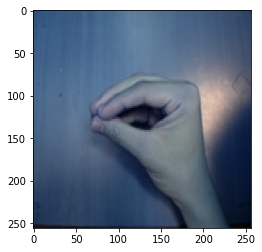

(Class :b'i', Label :8.0)


In [18]:
plt.imshow(x[0])
plt.show()

print(f'(Class :{c[0]}, Label :{y[0]})')